# 1. Module and data imports

In [1]:
# basics
import pandas as pd
import numpy as np
import missingno as msno

# plots
import  matplotlib.pyplot as  plt
import matplotlib.patches as mpatches
import seaborn as sns

# statistics plots
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from scipy.stats import probplot

# statistical tests and auto arima
from statsmodels.tsa.stattools import adfuller
import scipy.stats as stats
from pmdarima.arima import auto_arima
from arch import arch_model
from statsmodels.tsa.api import VAR

# metrics
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error, mean_squared_error


In [2]:
df = pd.read_excel('crude_oil_price.xlsx', engine='openpyxl', sheet_name='crude_oil')
df.rename(columns={'Date':'date', 'crude_oil_p_per_barrel':'CrudeOil'},inplace=True)


df.set_index('date', inplace=True)

Visual check for NAs

<AxesSubplot:>

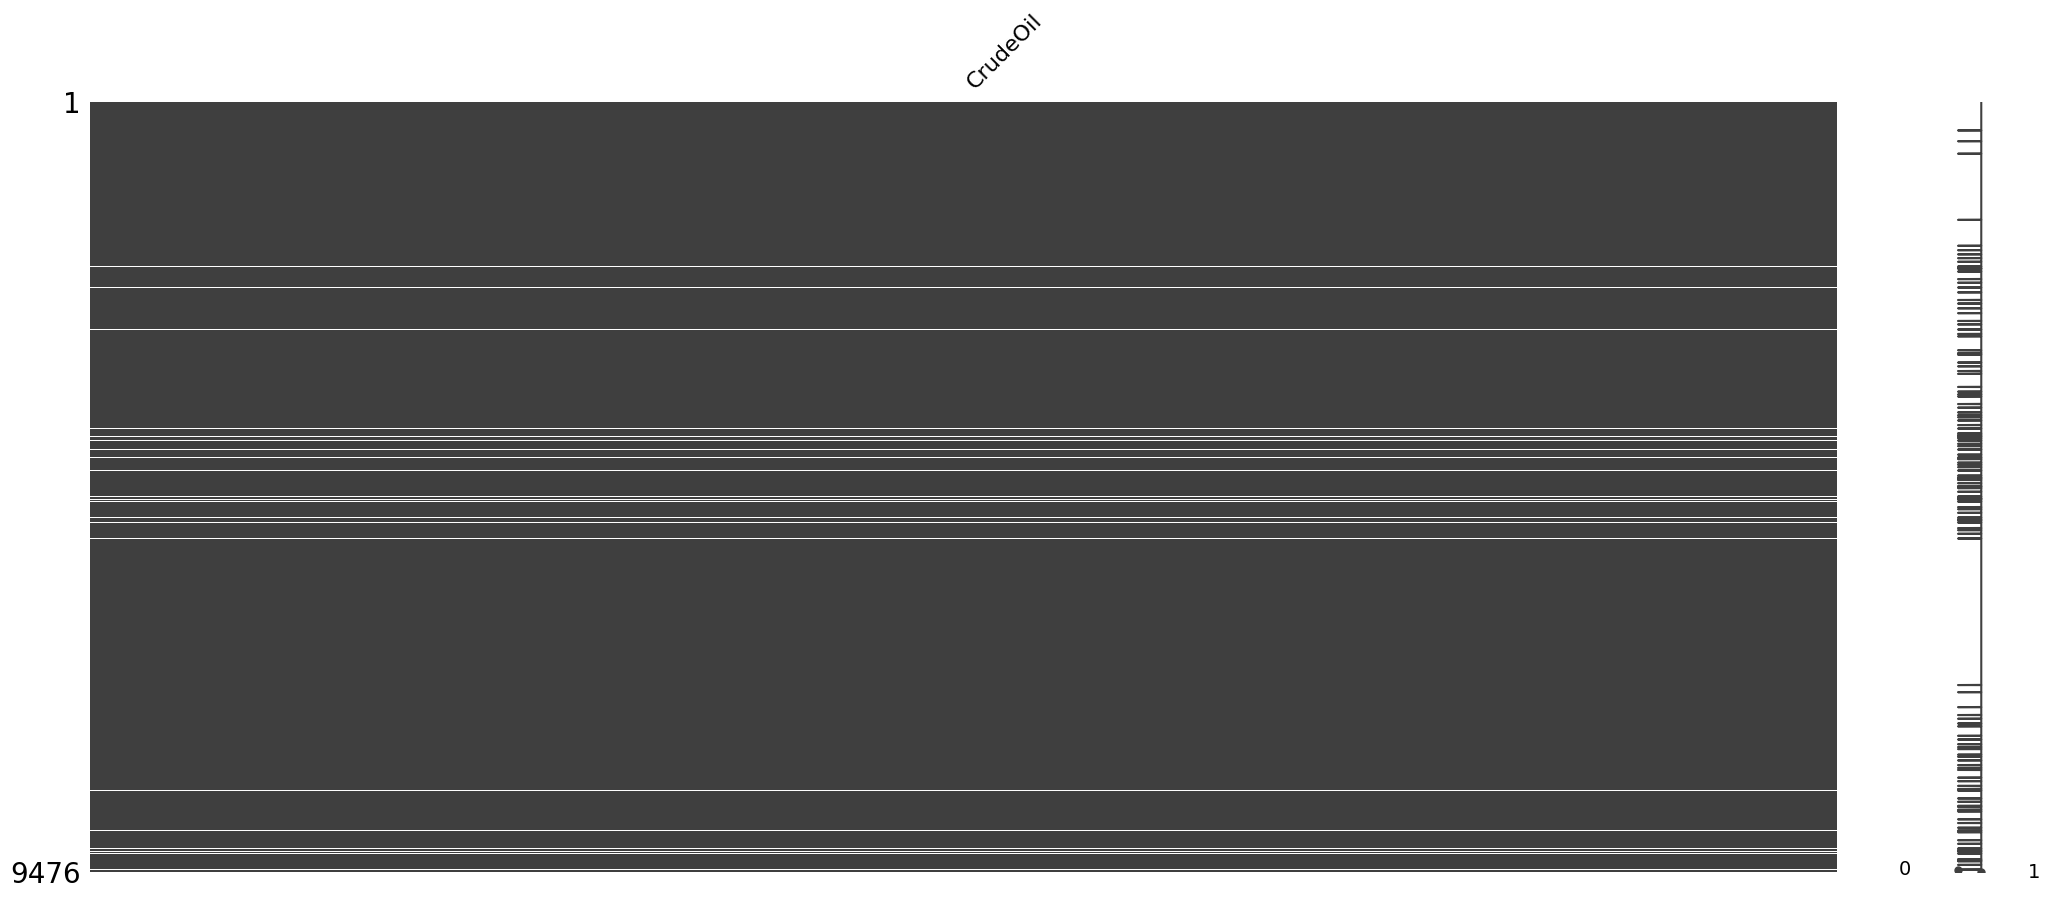

In [3]:
msno.matrix(df)

In [4]:
df.isna().sum()

CrudeOil    148
dtype: int64

In [5]:
df.ffill(inplace=True)

---
# 2. Exploratory Data Anaysis

Korekta ujemnej ceny kontraktów na ropę. Przyjąć cenę z dnia roboczego wcześniej (ceny kontraktów spadły poniżej 0 w dniu 20-04-2020)

Text(0.5, 1.0, 'Crude Oil price (barrel) 2019 to 2021')

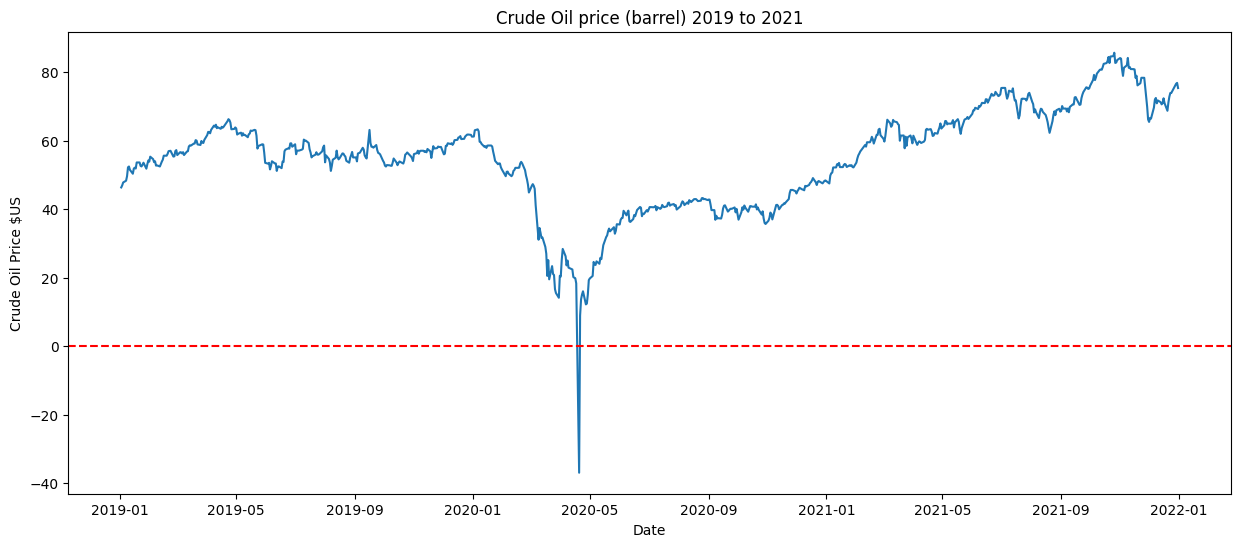

In [6]:
fig, ax = plt.subplots(figsize=(15,6))
sns.lineplot(x=df[(df.index.year >=2019) & (df.index.year <=2021)].index, y='CrudeOil', data=df[(df.index.year >=2019) & (df.index.year <=2021)],ax=ax)
ax.axhline(0, color='red', linestyle='--')
ax.set_ylabel('Crude Oil Price $US')
ax.set_xlabel('Date')
ax.set_title('Crude Oil price (barrel) 2019 to 2021')

In [7]:
display(df[df.CrudeOil<0])

df['CrudeOil'] = df.CrudeOil.apply(lambda x : x if x >= 0 else np.NaN)

display(df[df.index == '2020-04-20'])

df.interpolate(method='pad', inplace=True)

display(df[(df.index > '2020-04-15') & (df.index < '2020-04-25')])

,CrudeOil
date,
2020-04-20,-36.98


,CrudeOil
date,
2020-04-20,NaN


,CrudeOil
date,
2020-04-16,19.82
2020-04-17,18.31
2020-04-20,18.31
2020-04-21,8.91
2020-04-22,13.64
2020-04-23,15.06
2020-04-24,15.99


Creating percet change dataframe after correction of Crude Oil prices.

In [8]:
dfpc = df.copy()
dfpc = dfpc.pct_change().dropna()
dfpc.head()

,CrudeOil
date,
1986-01-03,0.017214
1986-01-06,0.020385
1986-01-07,-0.025631
1986-01-08,0.000774
1986-01-09,0.006185


## 2.1. Price and returns plots

Text(0.5, 1.0, 'Crude Oil returns 1986-01-02 to 2023-01-06')

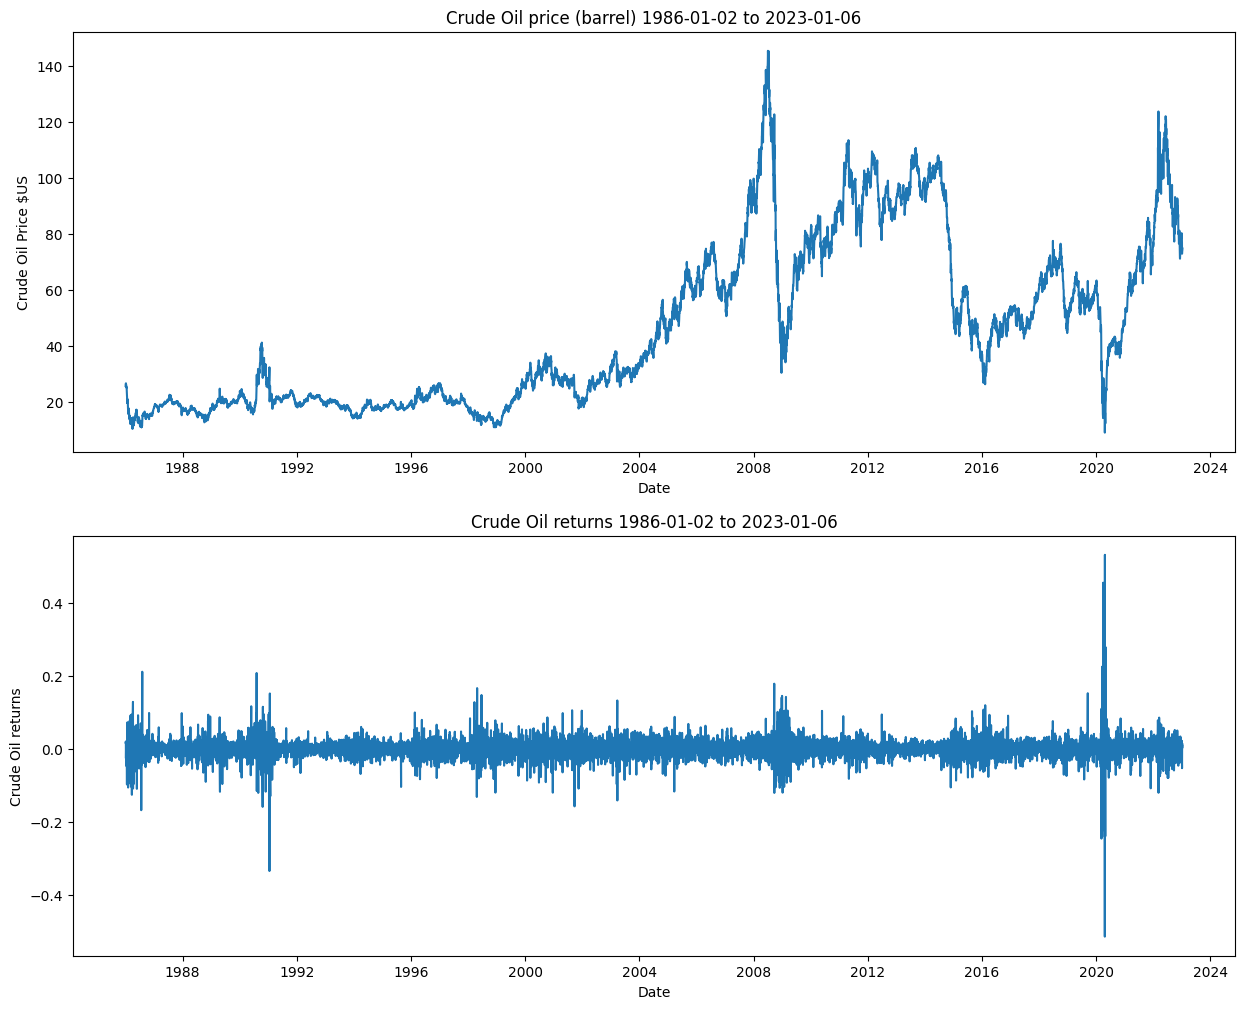

In [9]:
fig, (ax1, ax2) = plt.subplots(2,figsize=(15,12))

# price
sns.lineplot(x=df.index, y='CrudeOil', data=df, ax=ax1)
ax1.set_ylabel('Crude Oil Price $US')
ax1.set_xlabel('Date')
ax1.set_title('Crude Oil price (barrel) 1986-01-02 to 2023-01-06')

# returns
sns.lineplot(x=dfpc.index, y='CrudeOil', data=dfpc, ax=ax2)
ax2.set_ylabel('Crude Oil returns')
ax2.set_xlabel('Date')
ax2.set_title('Crude Oil returns 1986-01-02 to 2023-01-06')

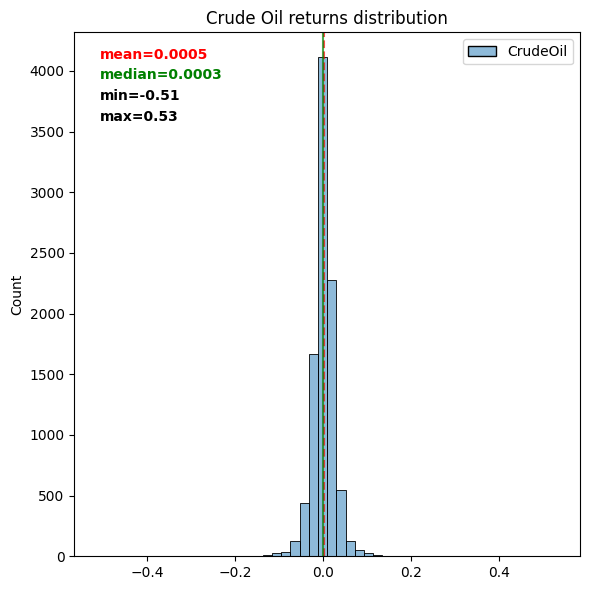

In [10]:
fig, ax = plt.subplots(figsize=(6,6))

sns.histplot(dfpc, ax=ax, bins=50)
mean = dfpc['CrudeOil'].mean()
median = dfpc['CrudeOil'].median()
miin = dfpc['CrudeOil'].min()
maax = dfpc['CrudeOil'].max()
ax.axvline(mean, color='red', linestyle='--', alpha=0.7)
ax.axvline(median, color='green', linestyle='-', alpha=0.7)
ax.text(0.05, 0.95, f'mean={mean:.4f}', color='red', transform=ax.transAxes, fontweight='bold')
ax.text(0.05, 0.91, f'median={(median):.4f}', color='green', transform=ax.transAxes, fontweight='bold')
ax.text(0.05, 0.87, f'min={miin:.2f}', color='black', transform=ax.transAxes, fontweight='bold')
ax.text(0.05, 0.83, f'max={maax:.2f}', color='black', transform=ax.transAxes, fontweight='bold')
ax.set_title('Crude Oil returns distribution')

plt.tight_layout()
plt.show()

c:\Users\maxim\Documents\GitHub\work-bench\venv\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


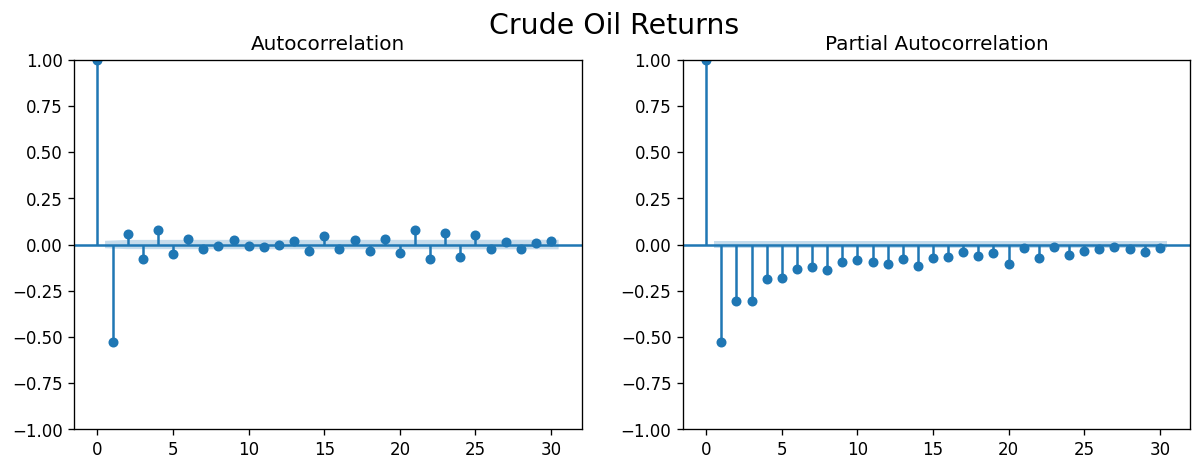

In [11]:
dfac = dfpc.copy()
dfac.reset_index(inplace=True, drop=True)

plt.rcParams.update({'figure.figsize':(12,4), 'figure.dpi':120})

fig, axes = plt.subplots(1, 2, sharex=False)
fig.suptitle('Crude Oil Returns', fontsize=17)
plot_acf(dfac['CrudeOil'].diff().dropna(), ax=axes[0], lags=30)
plot_pacf(dfac['CrudeOil'].diff().dropna(), ax=axes[1], lags=30)

plt.show()

<Figure size 1440x480 with 0 Axes>

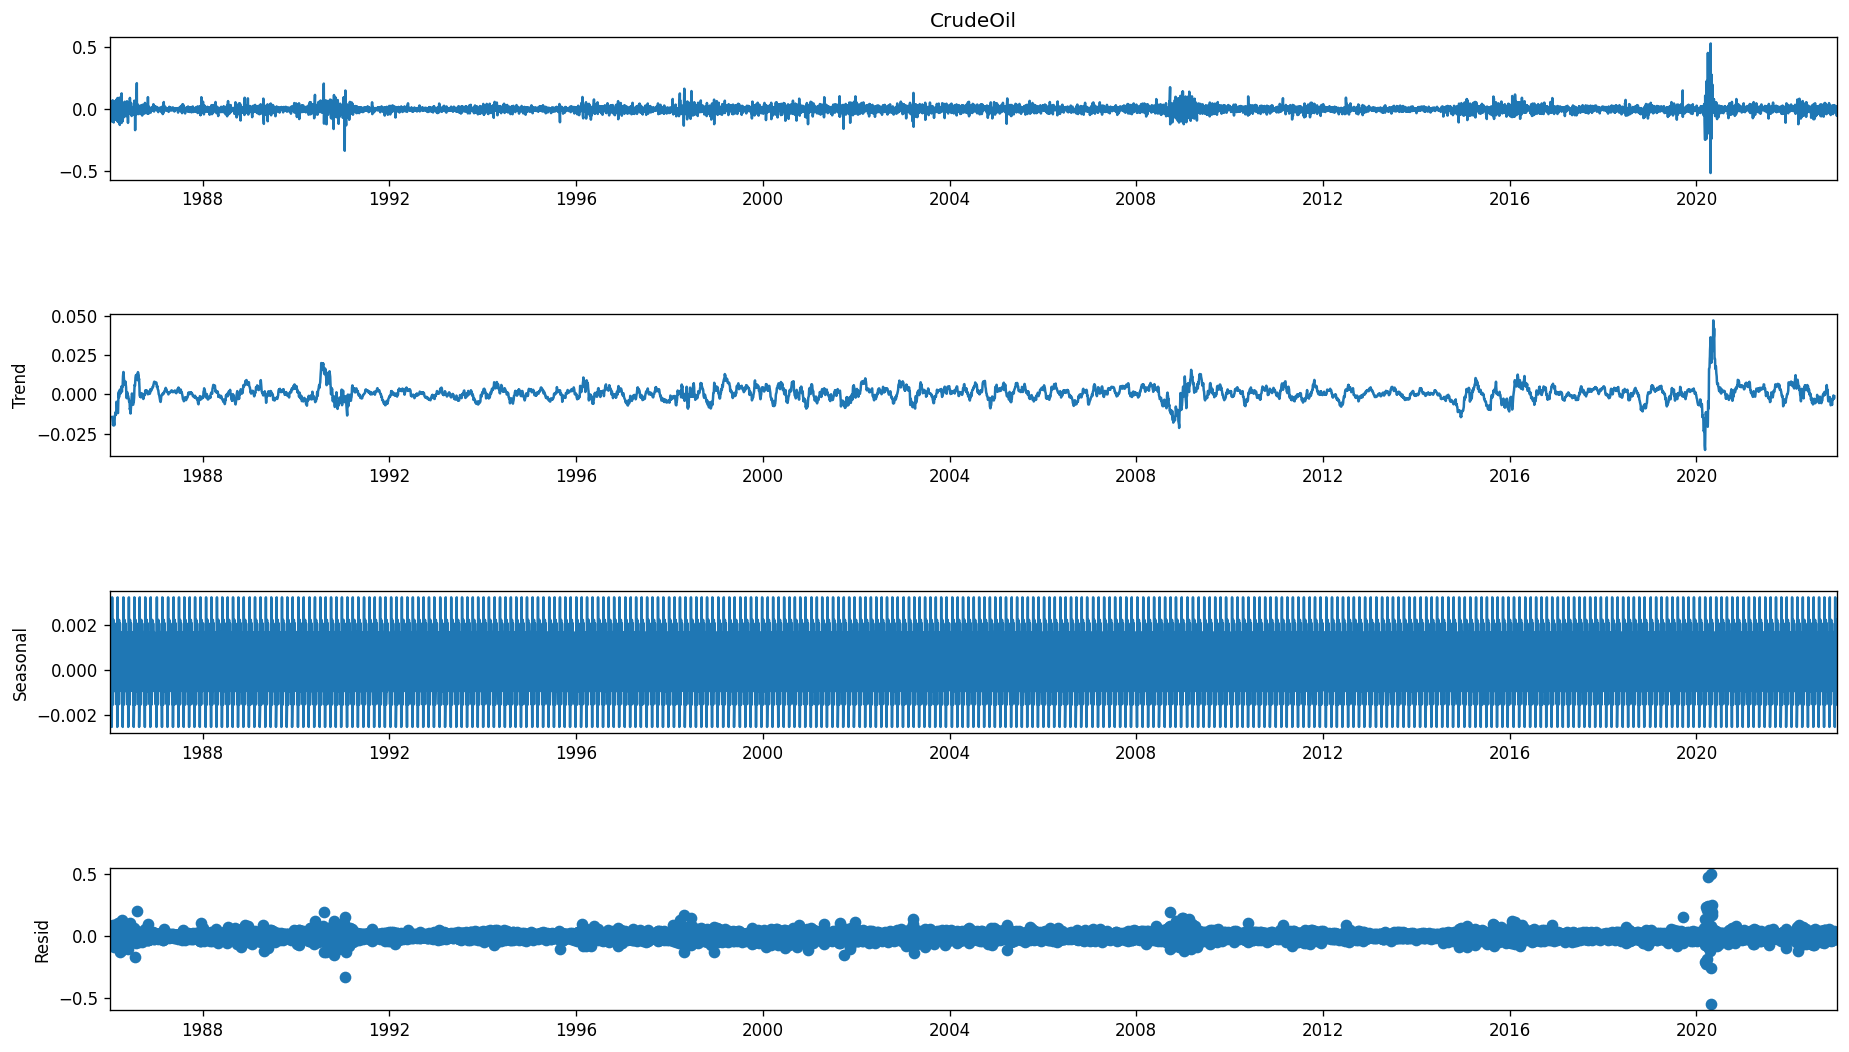

In [12]:
sd_plot  = seasonal_decompose(dfpc['CrudeOil'], model='additive', period=30)
fig = plt.figure()
fig = sd_plot.plot()
fig.set_size_inches(16,10)

In [13]:
def plot_test_stationarity(timeseries, name):

    adf = adfuller(timeseries,autolag='AIC')
    jb = stats.jarque_bera(timeseries)
    #Determing rolling statistics
    rolmean = timeseries.rolling(30).mean()
    rolstd = timeseries.rolling(30).std()
    #Plot rolling statistics:
    fig, ax = plt.subplots(figsize=(12,6))
    ax.plot(timeseries, color='blue',label='Original')
    ax.plot(rolmean, color='red', label='Rolling Mean')
    ax1 = ax.twinx()
    ax1.plot(rolstd, color='black', label = 'Rolling Std', alpha=0.7)
    ax1.set_ylim([0,1])
    ax.set_ylabel('Mean and price')
    ax1.set_ylabel('Std')

    blue_patch = mpatches.Patch(color='blue', label='Original')
    red_patch = mpatches.Patch(color='red', label='Rolling Mean')
    black_patch = mpatches.Patch(color='black', label='Rolling Std')
    fig.suptitle("Rolling Means and Standard Deviations", fontsize=20, x=0.5, y=1.07)
    fig.legend(handles=[red_patch, blue_patch, black_patch], bbox_to_anchor=(0.25,0.86))
    ax.title.set_text(f'{name}\nADF -> Test Statistic: {round(adf[0],2)}, p-value: {round(adf[1],2)}\nJarque Bera -> Test statistic {round(jb[0],2)}, p-value:{jb[1]}')
    

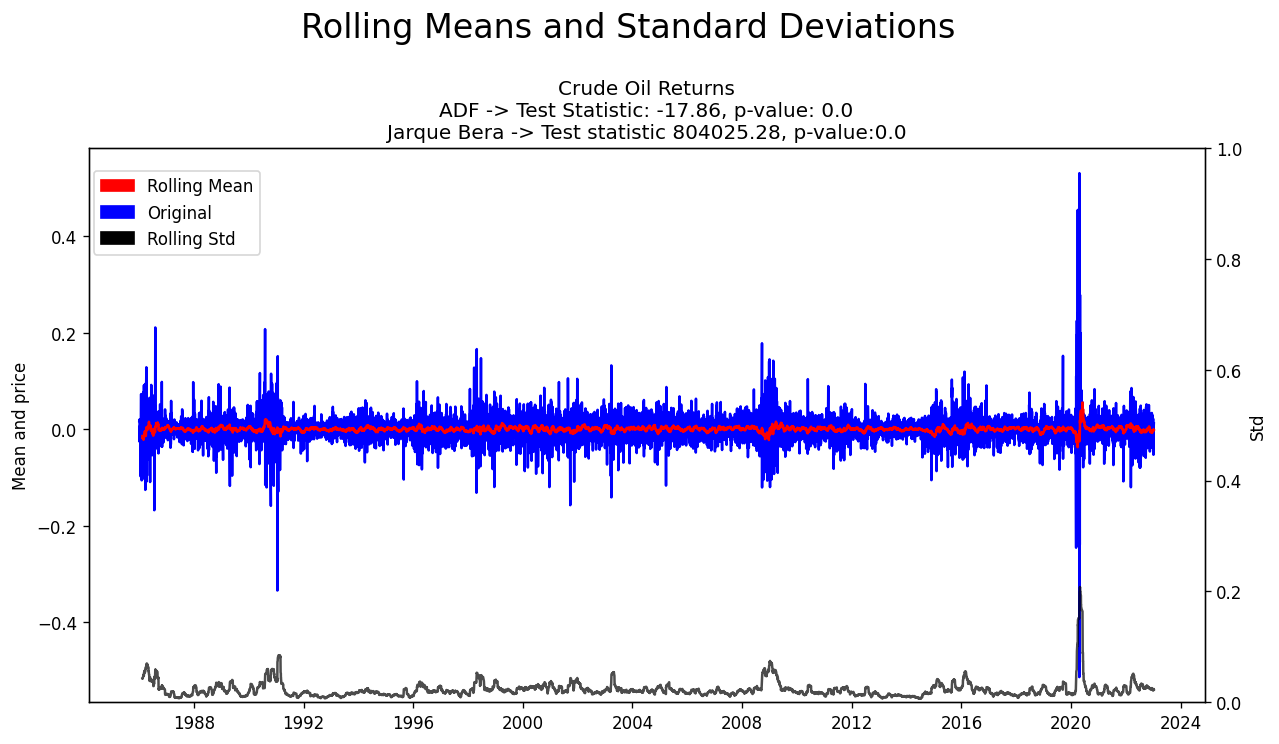

In [14]:
plot_test_stationarity(dfpc, "Crude Oil Returns")

---
# Modeling

# 3. ARIMA

Data split

In [15]:
dfpc[dfpc.index<'2022-10-01']

,CrudeOil
date,
1986-01-03,0.017214
1986-01-06,0.020385
1986-01-07,-0.025631
1986-01-08,0.000774
1986-01-09,0.006185
...,...
2022-09-26,-0.024029
2022-09-27,0.022548
2022-09-28,0.046889


In [16]:
dfpc[(dfpc.index.year==2022) & (dfpc.index.month==10)]

,CrudeOil
date,
2022-10-03,0.051808
2022-10-04,0.033551
2022-10-05,0.015540
2022-10-06,0.007708
2022-10-07,0.046907
2022-10-10,-0.015795
2022-10-11,-0.020197
2022-10-12,-0.021393
2022-10-13,0.020039


Text(0.5, 0, 'Date')

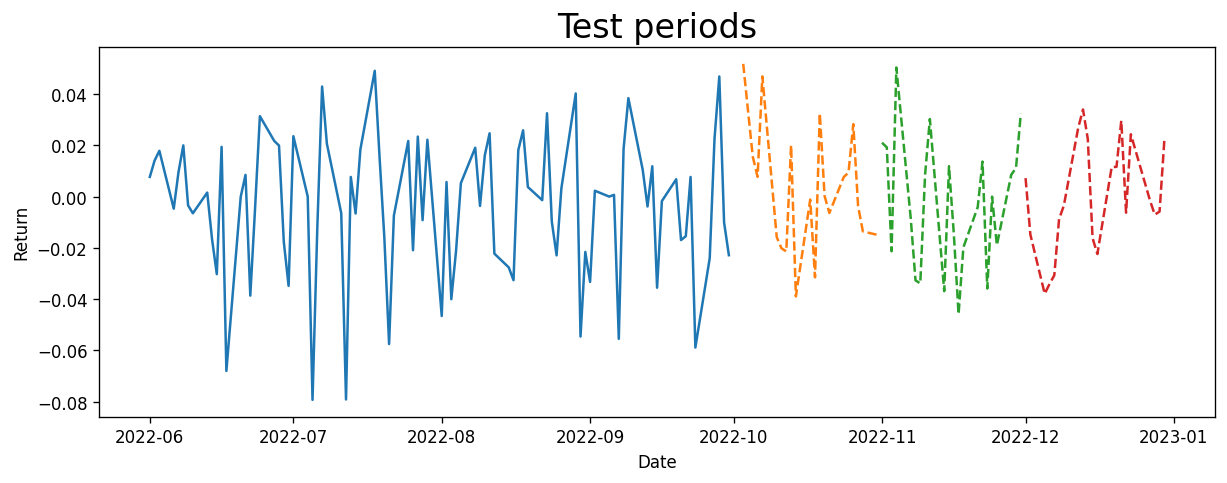

In [17]:
trainpart = dfpc[(dfpc.index.year==2022) & (dfpc.index.month.isin([6,7,8,9]))]
period1 = dfpc[(dfpc.index.year==2022) & (dfpc.index.month==10)]
period2 = dfpc[(dfpc.index.year==2022) & (dfpc.index.month==11)]
period3 = dfpc[(dfpc.index.year==2022) & (dfpc.index.month==12)]

plt.plot(trainpart.index, trainpart.CrudeOil)
plt.plot(period1.index, period1.CrudeOil, linestyle='--')
plt.plot(period2.index, period2.CrudeOil, linestyle='--')
plt.plot(period3.index, period3.CrudeOil, linestyle='--')
plt.title('Test periods', fontsize=20)
plt.ylabel('Return')
plt.xlabel('Date')

* ## Period 1 - October

In [18]:
y_train_price1, y_test_price1 = df[df.index<'2022-10-01'], df[(df.index.year==2022) & (df.index.month==10)]

In [19]:
y_train1, y_test1 =  dfpc[dfpc.index<'2022-10-01'], dfpc[(dfpc.index.year==2022) & (dfpc.index.month==10)]

c:\Users\maxim\Documents\GitHub\work-bench\venv\lib\site-packages\pmdarima\arima\_validation.py:62: UserWarning: m (7) set for non-seasonal fit. Setting to 0
  warnings.warn("m (%i) set for non-seasonal fit. Setting to 0" % m)
c:\Users\maxim\Documents\GitHub\work-bench\venv\lib\site-packages\pmdarima\arima\_validation.py:76: UserWarning: stepwise model cannot be fit in parallel (n_jobs=1). Falling back to stepwise parameter search.
  warnings.warn('stepwise model cannot be fit in parallel (n_jobs=%i). '


Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=-40783.698, Time=0.52 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=-40811.026, Time=0.23 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=-40811.237, Time=0.30 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=-40809.315, Time=0.44 sec
 ARIMA(0,0,2)(0,0,0)[0]             : AIC=-40809.349, Time=1.06 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=-40824.901, Time=2.57 sec
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=-40813.285, Time=4.05 sec
 ARIMA(1,0,3)(0,0,0)[0]             : AIC=-40855.528, Time=2.20 sec
 ARIMA(0,0,3)(0,0,0)[0]             : AIC=-40836.975, Time=2.30 sec
 ARIMA(2,0,3)(0,0,0)[0]             : AIC=-40850.031, Time=3.48 sec
 ARIMA(1,0,4)(0,0,0)[0]             : AIC=-40851.730, Time=3.88 sec
 ARIMA(0,0,4)(0,0,0)[0]             : AIC=-40845.276, Time=2.91 sec
 ARIMA(2,0,4)(0,0,0)[0]             : AIC=-40852.091, Time=4.30 sec
 ARIMA(1,0,3)(0,0,0)[0] intercept   : AIC=-40857.272, Time=9.72 sec
 ARIM

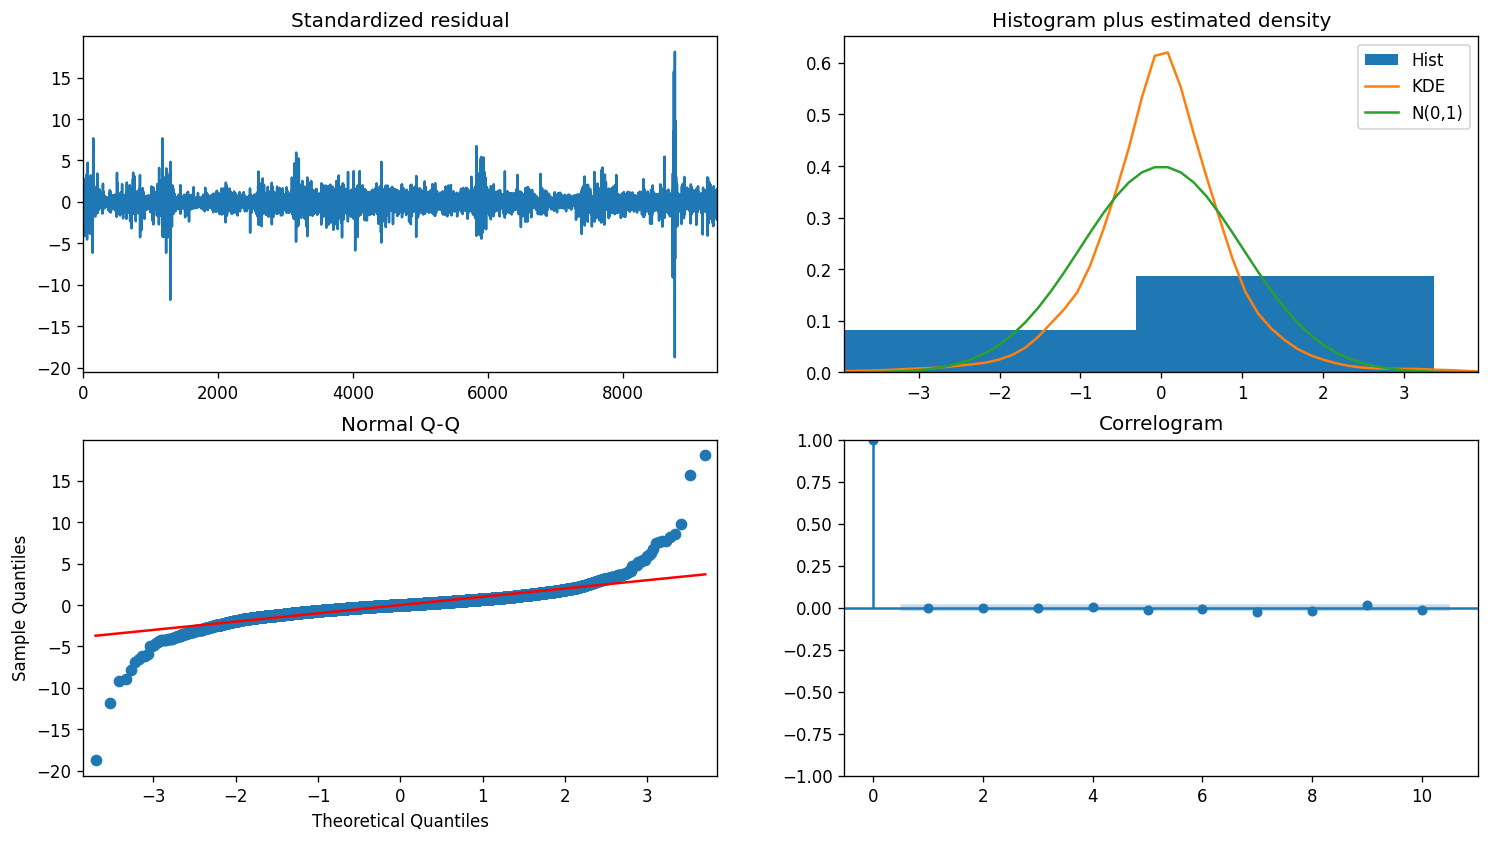

In [20]:
p1_autoARIMA = auto_arima(y_train1, 
                      start_p=0, 
                      start_q=0,
                      test='adf',       # use adftest to find optimal 'd'
                      m=7,             # frequency of series
                      d=None,           # let model determine 'd'
                      seasonal=False,   # No Seasonality
                      start_P=0,
                      trace=True,
                      error_action='ignore',  
                      suppress_warnings=True, 
                      stepwise=True,
                      maxiter=5000,
                      scoring='mse',
                      n_jobs=-1)
print(p1_autoARIMA.summary())
p1_autoARIMA.plot_diagnostics(figsize=(15,8))
plt.show()

Summary of model above

In [21]:
p1_autoARIMA.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                 9406
Model:               SARIMAX(1, 0, 3)   Log Likelihood               20434.636
Date:                Mon, 17 Apr 2023   AIC                         -40857.272
Time:                        22:13:33   BIC                         -40814.377
Sample:                             0   HQIC                        -40842.708
                               - 9406                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0008      0.000      1.933      0.053   -1.13e-05       0.002
ar.L1         -0.6106      0.036    -16.870      0.000      -0.682      -0.540
ma.L1          0.5569      0.035     15.771      0.000       0.488       0.626
ma.L2         -0.0373      0.005     -7.289      0.000      -0.047      -0.027
ma.L3         -0.0600      0.004    -13.773      0.000      -0.069      -0.051
sigma2         0.0008   2.73e-06    277.741      0.000       0.001       0.001
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):            666351.46
Prob(Q):                              0.98   Prob(JB):                         0.00
Heteroskedasticity (H):               1.48   Skew:                             0.32
Prob(H) (two-sided):                  0.00   Kurtosis:                        44.23
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [22]:
y_hat_p1 = p1_autoARIMA.predict(y_test1.shape[0])

c:\Users\maxim\Documents\GitHub\work-bench\venv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


In [23]:
y_hat_p1

9406   -0.000263
9407    0.002274
9408    0.000798
9409    0.000330
9410    0.000616
9411    0.000442
9412    0.000548
9413    0.000483
9414    0.000523
9415    0.000498
9416    0.000513
9417    0.000504
9418    0.000510
9419    0.000506
9420    0.000508
9421    0.000507
9422    0.000508
9423    0.000507
9424    0.000508
9425    0.000508
9426    0.000508
dtype: float64

In [24]:
y_hat_p1 = pd.DataFrame(y_hat_p1)
y_hat_p1.index = y_test1.index
y_hat_p1

,0
date,
2022-10-03,-0.000263
2022-10-04,0.002274
2022-10-05,0.000798
2022-10-06,0.000330
2022-10-07,0.000616
2022-10-10,0.000442
2022-10-11,0.000548
2022-10-12,0.000483
2022-10-13,0.000523


In [25]:
def get_prices(initial_price:float, return_array):
    '''Helper function to transform returns data into price data'''
    price_arr = np.array([])
    for i in return_array:
        initial_price = initial_price*(i+1)
        price_arr = np.append(price_arr, initial_price)
    
    return price_arr

In [26]:
y_hat_prices1 = get_prices(y_train_price1.CrudeOil.iloc[-1], y_hat_p1[0])
y_hat_prices1

array([79.88900728, 80.07068911, 80.13457665, 80.16105372, 80.210421  ,
       80.24583869, 80.28981195, 80.32859198, 80.37057797, 80.41063877,
       80.45190905, 80.49247383, 80.53350299, 80.57428187, 80.61524707,
       80.65613189, 80.69709927, 80.73804969, 80.77904397, 80.82004496,
       80.86107537])

In [27]:
y_hat_prices1 = get_prices(y_train_price1.CrudeOil.iloc[-1], y_hat_p1[0])

y_hat_prices1 = pd.DataFrame(y_hat_prices1)
y_hat_prices1.index = y_test_price1.index
y_hat_prices1

,0
date,
2022-10-03,79.889007
2022-10-04,80.070689
2022-10-05,80.134577
2022-10-06,80.161054
2022-10-07,80.210421
2022-10-10,80.245839
2022-10-11,80.289812
2022-10-12,80.328592
2022-10-13,80.370578


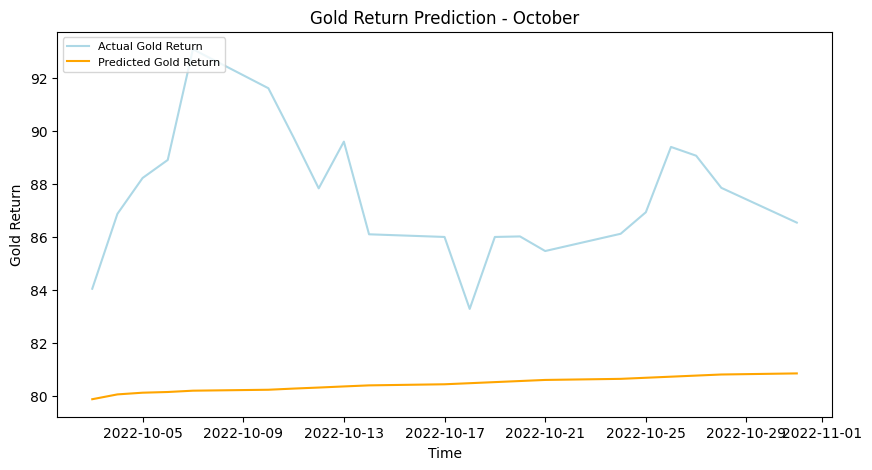

In [28]:
#fc_series = pd.Series(fc, index=test_data.index)
#lower_series = pd.Series(conf[:, 0], index=test_data.index)
#upper_series = pd.Series(conf[:, 1], index=test_data.index)
# Plot
plt.figure(figsize=(10,5), dpi=100)
#plt.plot(inv_ytr[inv_ytr.index > '2019-12-31'], label='training data')
plt.plot(y_test_price1, color = 'lightblue', label='Actual Gold Return')
plt.plot(y_hat_prices1[0], color = 'orange',label='Predicted Gold Return')
#plt.fill_between(lower_series.index, lower_series, upper_series, 
#                 color='k', alpha=.10)
plt.title('Gold Return Prediction - October')
plt.xlabel('Time')
plt.ylabel('Gold Return')
plt.legend(loc='upper left', fontsize=8)
plt.show()

In [29]:
g_mae = mean_absolute_error(y_test_price1, y_hat_prices1)
g_mape = mean_absolute_percentage_error(y_test_price1, y_hat_prices1)
g_mse = mean_squared_error(y_test_price1, y_hat_prices1)
g_rmse = np.sqrt(g_mse)

print(f'MAE: {g_mae}\nMAPE: {g_mape}\nMSE: {g_mse}\nRMSE: {g_rmse}')

MAE: 7.1104729958850585
MAPE: 0.08057069004435274
MSE: 56.105938580567084
RMSE: 7.490389748241882


In [30]:
metric_dict = {'Month':[], 'MAE':[], 'MAPE':[], 'MSE':[], 'RMSE':[]}

metric_dict['Month'].append('October')
metric_dict['MAE'].append(g_mae)
metric_dict['MAPE'].append(g_mape)
metric_dict['MSE'].append(g_mse)
metric_dict['RMSE'].append(g_rmse)

* ## Period 2 - November

In [31]:
y_train_price2, y_test_price2 = df[df.index<'2022-11-01'], df[(df.index.year==2022) & (df.index.month==11)]

y_train2, y_test2 =  dfpc[dfpc.index<'2022-11-01'], dfpc[(dfpc.index.year==2022) & (dfpc.index.month==11)]

c:\Users\maxim\Documents\GitHub\work-bench\venv\lib\site-packages\pmdarima\arima\_validation.py:62: UserWarning: m (7) set for non-seasonal fit. Setting to 0
  warnings.warn("m (%i) set for non-seasonal fit. Setting to 0" % m)
c:\Users\maxim\Documents\GitHub\work-bench\venv\lib\site-packages\pmdarima\arima\_validation.py:76: UserWarning: stepwise model cannot be fit in parallel (n_jobs=1). Falling back to stepwise parameter search.
  warnings.warn('stepwise model cannot be fit in parallel (n_jobs=%i). '


Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=-40879.045, Time=0.62 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=-40906.353, Time=0.44 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=-40906.555, Time=0.62 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=-40904.602, Time=0.42 sec
 ARIMA(0,0,2)(0,0,0)[0]             : AIC=-40904.647, Time=1.70 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=-40923.070, Time=4.18 sec
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=-40908.821, Time=7.65 sec
 ARIMA(1,0,3)(0,0,0)[0]             : AIC=-40951.249, Time=1.33 sec
 ARIMA(0,0,3)(0,0,0)[0]             : AIC=-40932.118, Time=0.96 sec
 ARIMA(2,0,3)(0,0,0)[0]             : AIC=-40945.726, Time=0.58 sec
 ARIMA(1,0,4)(0,0,0)[0]             : AIC=-40947.228, Time=1.55 sec
 ARIMA(0,0,4)(0,0,0)[0]             : AIC=-40940.935, Time=1.21 sec
 ARIMA(2,0,4)(0,0,0)[0]             : AIC=-40947.919, Time=2.30 sec
 ARIMA(1,0,3)(0,0,0)[0] intercept   : AIC=-40953.077, Time=4.46 sec
 ARIM

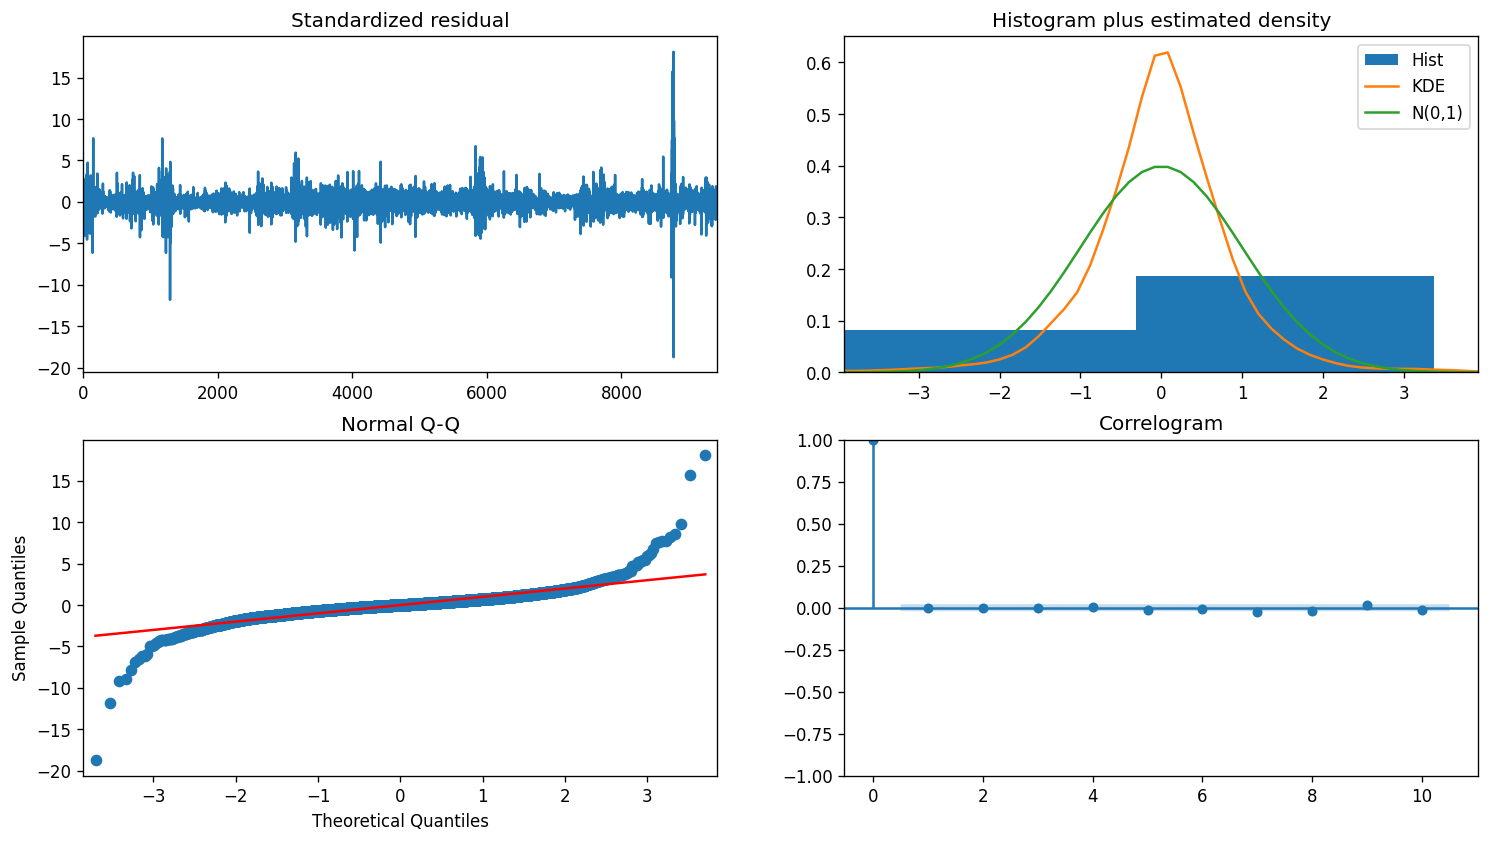

In [32]:
p2_autoARIMA = auto_arima(y=y_train2, 
                      start_p=0, 
                      start_q=0,
                      test='adf',       # use adftest to find optimal 'd'
                      m=7,             # frequency of series
                      d=None,           # let model determine 'd'
                      seasonal=False,   # No Seasonality
                      start_P=0,
                      trace=True,
                      error_action='ignore',  
                      suppress_warnings=True, 
                      stepwise=True,
                      maxiter=500,
                      scoring='mse',
                      n_jobs=-1)
print(p2_autoARIMA.summary())
p2_autoARIMA.plot_diagnostics(figsize=(15,8))
plt.show()

In [33]:
p2_autoARIMA.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                 9427
Model:               SARIMAX(1, 0, 3)   Log Likelihood               20482.539
Date:                Mon, 17 Apr 2023   AIC                         -40953.077
Time:                        22:14:45   BIC                         -40910.169
Sample:                             0   HQIC                        -40938.510
                               - 9427                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0008      0.000      1.968      0.049    3.46e-06       0.002
ar.L1         -0.6094      0.036    -16.714      0.000      -0.681      -0.538
ma.L1          0.5558      0.036     15.622      0.000       0.486       0.626
ma.L2         -0.0370      0.005     -7.233      0.000      -0.047      -0.027
ma.L3         -0.0597      0.004    -13.712      0.000      -0.068      -0.051
sigma2         0.0008   2.73e-06    277.876      0.000       0.001       0.001
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):            666483.91
Prob(Q):                              0.98   Prob(JB):                         0.00
Heteroskedasticity (H):               1.48   Skew:                             0.32
Prob(H) (two-sided):                  0.00   Kurtosis:                        44.19
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [34]:
y_hat_p2 = p2_autoARIMA.predict(y_test2.shape[0])

c:\Users\maxim\Documents\GitHub\work-bench\venv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


In [35]:
y_hat_p2

9427    0.002393
9428    0.000742
9429    0.001257
9430    0.000065
9431    0.000791
9432    0.000349
9433    0.000618
9434    0.000454
9435    0.000554
9436    0.000493
9437    0.000530
9438    0.000508
9439    0.000521
9440    0.000513
9441    0.000518
9442    0.000515
9443    0.000517
9444    0.000516
9445    0.000517
9446    0.000516
9447    0.000516
9448    0.000516
dtype: float64

In [36]:
y_hat_p2 = pd.DataFrame(y_hat_p2)
y_hat_p2.index = y_test2.index
y_hat_p2

,0
date,
2022-11-01,0.002393
2022-11-02,0.000742
2022-11-03,0.001257
2022-11-04,0.000065
2022-11-07,0.000791
2022-11-08,0.000349
2022-11-09,0.000618
2022-11-10,0.000454
2022-11-11,0.000554


In [37]:
y_hat_prices2 = get_prices(y_train_price2.CrudeOil.iloc[-1], y_hat_p2[0])

y_hat_prices2 = pd.DataFrame(y_hat_prices2)
y_hat_prices2.index = y_test2.index
y_hat_prices2

,0
date,
2022-11-01,86.747074
2022-11-02,86.811458
2022-11-03,86.920619
2022-11-04,86.926231
2022-11-07,86.995033
2022-11-08,87.025352
2022-11-09,87.079173
2022-11-10,87.118704
2022-11-11,87.166985


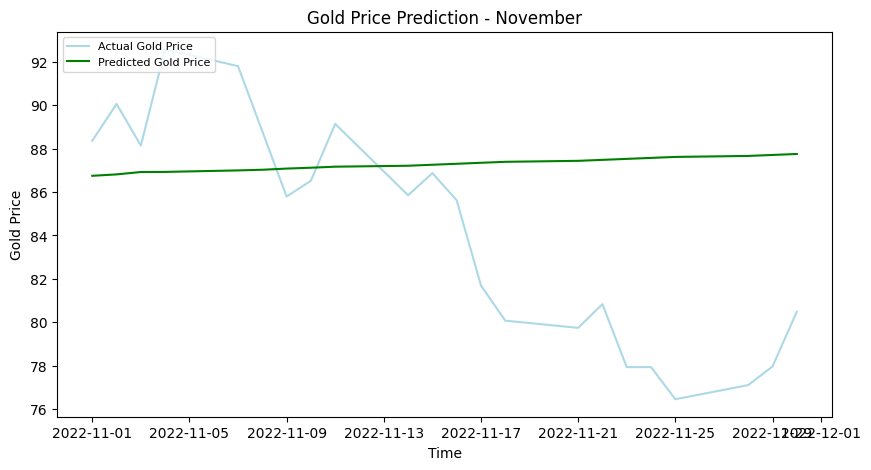

In [38]:
plt.figure(figsize=(10,5), dpi=100)
#plt.plot(inv_ytr[inv_ytr.index > '2019-12-31'], label='training data')
plt.plot(y_test_price2, color = 'lightblue', label='Actual Gold Price')
plt.plot(y_hat_prices2[0], color = 'green',label='Predicted Gold Price')
#plt.fill_between(lower_series.index, lower_series, upper_series, 
#                 color='k', alpha=.10)
plt.title('Gold Price Prediction - November')
plt.xlabel('Time')
plt.ylabel('Gold Price')
plt.legend(loc='upper left', fontsize=8)
plt.show()

In [39]:
g_mae = mean_absolute_error(y_test_price2, y_hat_prices2)
g_mape = mean_absolute_percentage_error(y_test_price2, y_hat_prices2)
g_mse = mean_squared_error(y_test_price2, y_hat_prices2)
g_rmse = np.sqrt(g_mse)

print(f'MAE: {g_mae}\nMAPE: {g_mape}\nMSE: {g_mse}\nRMSE: {g_rmse}')

MAE: 5.041479849042059
MAPE: 0.06228787087447785
MSE: 38.2652693037873
RMSE: 6.185892765299711


In [40]:
metric_dict['Month'].append('November')
metric_dict['MAE'].append(g_mae)
metric_dict['MAPE'].append(g_mape)
metric_dict['MSE'].append(g_mse)
metric_dict['RMSE'].append(g_rmse)

* ## Period 3 - December

In [41]:
y_train_price3, y_test_price3 = df[df.index<'2022-12-01'], df[(df.index.year==2022) & (df.index.month==12)]

y_train3, y_test3 = dfpc[dfpc.index<'2022-12-01'], dfpc[(dfpc.index.year==2022) & (dfpc.index.month==12)]

c:\Users\maxim\Documents\GitHub\work-bench\venv\lib\site-packages\pmdarima\arima\_validation.py:62: UserWarning: m (7) set for non-seasonal fit. Setting to 0
  warnings.warn("m (%i) set for non-seasonal fit. Setting to 0" % m)
c:\Users\maxim\Documents\GitHub\work-bench\venv\lib\site-packages\pmdarima\arima\_validation.py:76: UserWarning: stepwise model cannot be fit in parallel (n_jobs=1). Falling back to stepwise parameter search.
  warnings.warn('stepwise model cannot be fit in parallel (n_jobs=%i). '


Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=-40977.667, Time=0.50 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=-41005.046, Time=0.27 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=-41005.260, Time=0.39 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=-41003.353, Time=0.52 sec
 ARIMA(0,0,2)(0,0,0)[0]             : AIC=-41003.369, Time=1.55 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=-41021.577, Time=4.31 sec
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=-41007.473, Time=6.46 sec
 ARIMA(1,0,3)(0,0,0)[0]             : AIC=-41049.904, Time=1.34 sec
 ARIMA(0,0,3)(0,0,0)[0]             : AIC=-41030.763, Time=1.51 sec
 ARIMA(2,0,3)(0,0,0)[0]             : AIC=-41044.622, Time=1.08 sec
 ARIMA(1,0,4)(0,0,0)[0]             : AIC=-41046.130, Time=2.31 sec
 ARIMA(0,0,4)(0,0,0)[0]             : AIC=-41039.773, Time=1.80 sec
 ARIMA(2,0,4)(0,0,0)[0]             : AIC=-41046.571, Time=2.39 sec
 ARIMA(1,0,3)(0,0,0)[0] intercept   : AIC=-41051.611, Time=11.80 sec
 ARI

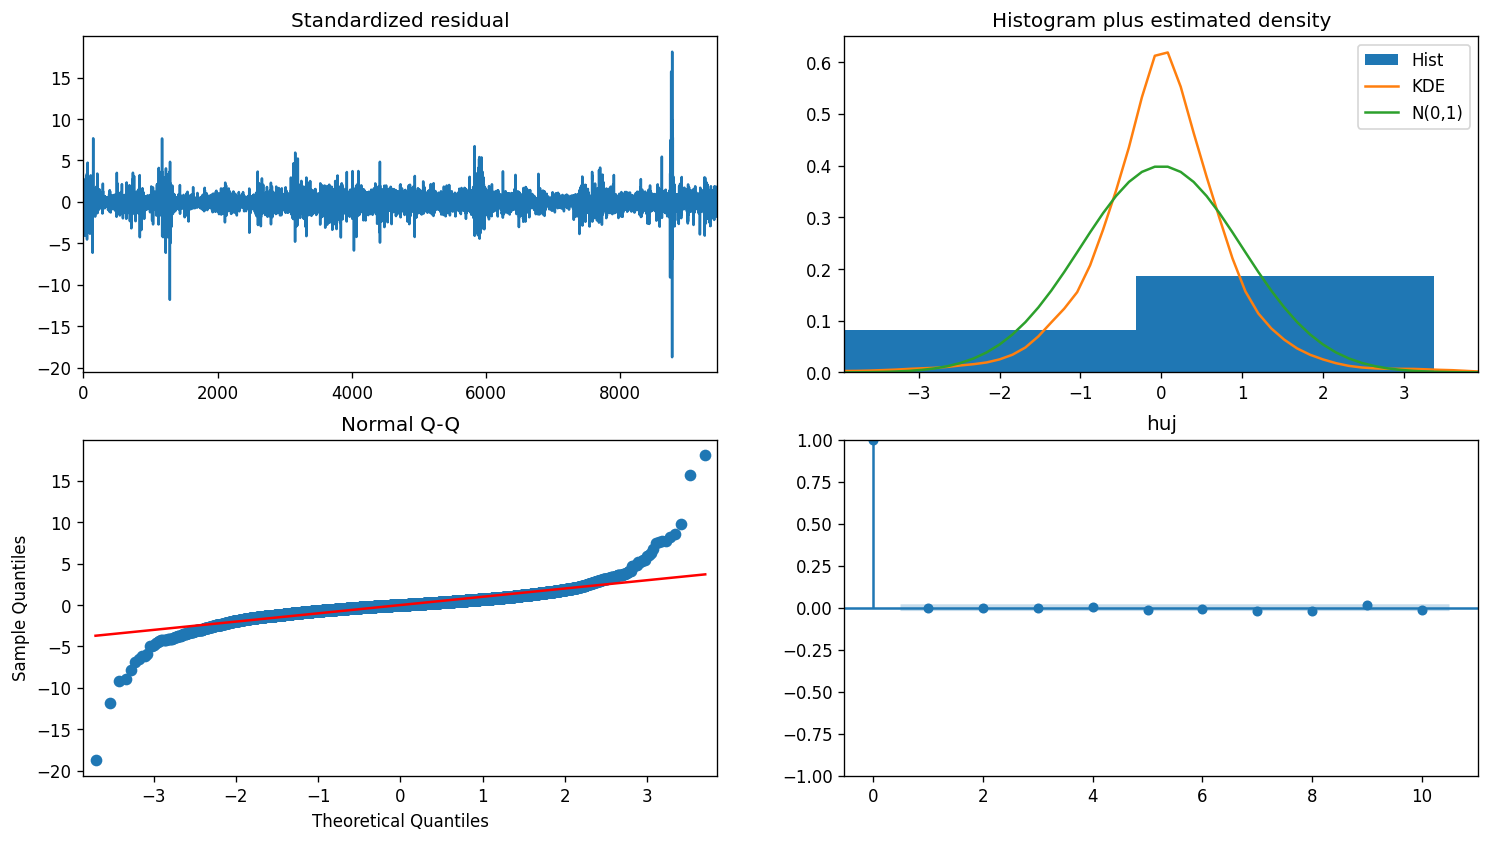

In [42]:
p3_autoARIMA = auto_arima(y_train3, 
                      start_p=0, 
                      start_q=0,
                      test='adf',       # use adftest to find optimal 'd'
                      m=7,             # frequency of series
                      d=None,           # let model determine 'd'
                      seasonal=False,   # No Seasonality
                      start_P=0,
                      trace=True,
                      error_action='ignore',  
                      suppress_warnings=True, 
                      stepwise=True,
                      maxiter=500,
                      scoring='mse',
                      n_jobs=-1)
print(p3_autoARIMA.summary())
p3_autoARIMA.plot_diagnostics(figsize=(15,8))
plt.title('huj')
plt.show()

In [43]:
p3_autoARIMA.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                 9449
Model:               SARIMAX(1, 0, 3)   Log Likelihood               20531.805
Date:                Mon, 17 Apr 2023   AIC                         -41051.611
Time:                        22:16:10   BIC                         -41008.689
Sample:                             0   HQIC                        -41037.041
                               - 9449                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0008      0.000      1.937      0.053   -9.75e-06       0.002
ar.L1         -0.6099      0.036    -16.743      0.000      -0.681      -0.539
ma.L1          0.5563      0.036     15.651      0.000       0.487       0.626
ma.L2         -0.0372      0.005     -7.271      0.000      -0.047      -0.027
ma.L3         -0.0597      0.004    -13.728      0.000      -0.068      -0.051
sigma2         0.0008   2.73e-06    277.973      0.000       0.001       0.001
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):            665794.74
Prob(Q):                              0.98   Prob(JB):                         0.00
Heteroskedasticity (H):               1.48   Skew:                             0.32
Prob(H) (two-sided):                  0.00   Kurtosis:                        44.12
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [44]:
y_hat_p3 = p3_autoARIMA.predict(y_test3.shape[0])

c:\Users\maxim\Documents\GitHub\work-bench\venv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


In [45]:
y_hat_p3 = pd.DataFrame(y_hat_p3)
y_hat_p3.index = y_test3.index
y_hat_p3

,0
date,
2022-12-01,-0.002619
2022-12-02,0.000548
2022-12-05,-0.001342
2022-12-06,0.001635
2022-12-07,-0.000181
2022-12-08,0.000927
2022-12-09,0.000251
2022-12-12,0.000663
2022-12-13,0.000412


In [46]:
y_hat_prices3 = get_prices(y_train_price3.CrudeOil.iloc[-1], y_hat_p3[0])

y_hat_prices3 = pd.DataFrame(y_hat_prices3)
y_hat_prices3.index = y_test3.index
y_hat_prices3

,0
date,
2022-12-01,80.269231
2022-12-02,80.313252
2022-12-05,80.205453
2022-12-06,80.336618
2022-12-07,80.322100
2022-12-08,80.396553
2022-12-09,80.416762
2022-12-12,80.470111
2022-12-13,80.503272


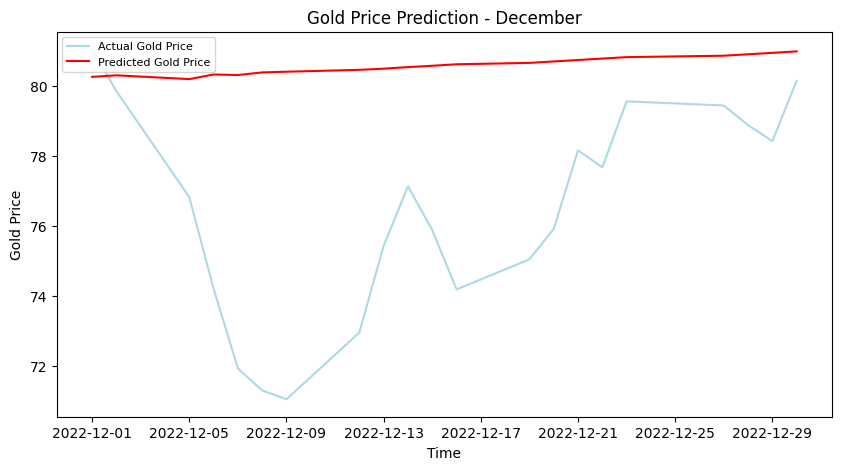

In [47]:
plt.figure(figsize=(10,5), dpi=100)
#plt.plot(inv_ytr[inv_ytr.index > '2019-12-31'], label='training data')
plt.plot(y_test_price3, color = 'lightblue', label='Actual Gold Price')
plt.plot(y_hat_prices3[0], color = 'red',label='Predicted Gold Price')
#plt.fill_between(lower_series.index, lower_series, upper_series, 
#                 color='k', alpha=.10)
plt.title('Gold Price Prediction - December')
plt.xlabel('Time')
plt.ylabel('Gold Price')
plt.legend(loc='upper left', fontsize=8)
plt.show()

In [48]:
g_mae = mean_absolute_error(y_test_price3, y_hat_prices3)
g_mape = mean_absolute_percentage_error(y_test_price3, y_hat_prices3)
g_mse = mean_squared_error(y_test_price3, y_hat_prices3)
g_rmse = np.sqrt(g_mse)

print(f'MAE: {g_mae}\nMAPE: {g_mape}\nMSE: {g_mse}\nRMSE: {g_rmse}')

MAE: 4.233410592459249
MAPE: 0.0568643291589475
MSE: 25.407066748307074
RMSE: 5.040542306965301


In [49]:
metric_dict['Month'].append('December')
metric_dict['MAE'].append(g_mae)
metric_dict['MAPE'].append(g_mape)
metric_dict['MSE'].append(g_mse)
metric_dict['RMSE'].append(g_rmse)

## ARIMA final results

In [50]:
metrics_df = pd.DataFrame(metric_dict)
metrics_df['MAE'], metrics_df['MAPE'], metrics_df['MSE'], metrics_df['RMSE'] = round(metrics_df['MAE'],2), round(metrics_df['MAPE'],2), round(metrics_df['MSE'],2), round(metrics_df['RMSE'],2)

metrics_df

,Month,MAE,MAPE,MSE,RMSE
0,October,7.11,0.08,56.11,7.49
1,November,5.04,0.06,38.27,6.19
2,December,4.23,0.06,25.41,5.04


Text(0.5, 0, 'Date')

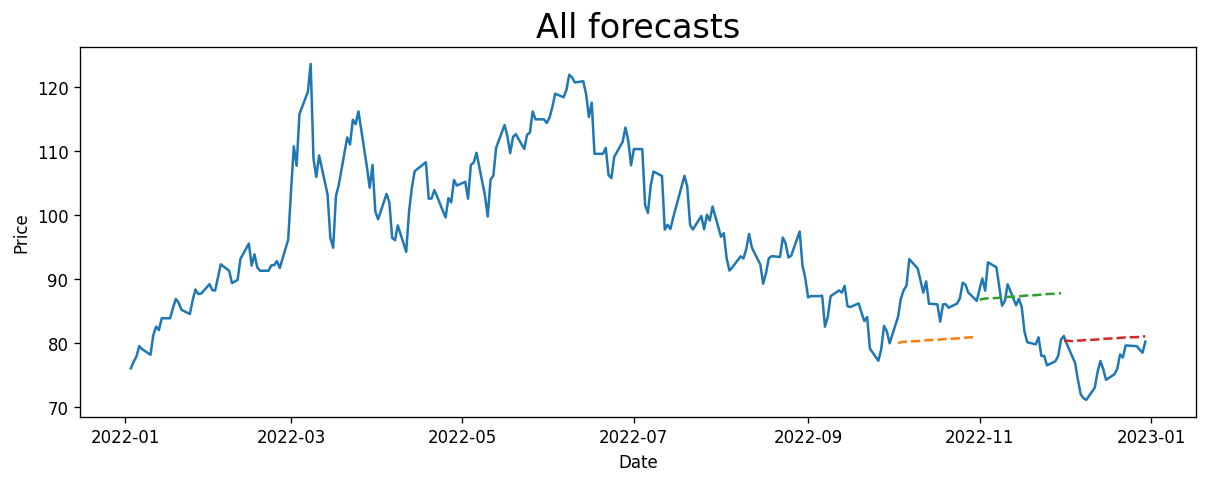

In [51]:
histpart = df[df.index.year==2022]

plt.plot(histpart.index, histpart.CrudeOil)
plt.plot(y_hat_prices1.index, y_hat_prices1[0], linestyle='--')
plt.plot(y_hat_prices2.index, y_hat_prices2[0], linestyle='--')
plt.plot(y_hat_prices3.index, y_hat_prices3[0], linestyle='--')
plt.title('All forecasts', fontsize=20)
plt.ylabel('Price')
plt.xlabel('Date')

---
# 4. VAR
Data split

In [52]:
# dfc = pd.read_csv('eurusd.csv', usecols=['Date', 'Price'])
# dfc['Date'] = pd.to_datetime(dfc['Date'])
# dfc.set_index('Date', inplace=True)

In [53]:
# dff = df.merge(dfc, left_index=True, right_index=True)
# dff.rename(columns={'Price':'EURUSD'}, inplace=True)
# dff

In [54]:
# graph = sns.jointplot(data=dff,x='CrudeOil', y='EURUSD')
# r, p = stats.pearsonr(dff['CrudeOil'], dff['EURUSD'])
# # if you choose to write your own legend, then you should adjust the properties then
# phantom, = graph.ax_joint.plot([], [], linestyle="", alpha=0)
# # here graph is not a ax but a joint grid, so we access the axis through ax_joint method

# graph.ax_joint.legend([phantom],['r={:f}, p={:f}'.format(r,p)])

In [55]:
# y_trainv, y_testv = dfpc[dfpc.index<'2022-12-01'], dfpc[(dfpc.index.year==2022) & (dfpc.index.month==12)]

In [56]:
# dff.corr()

In [57]:
# y_train_v, y_test_v = dff[dff.index<'2022-12-01'], dff[(dff.index.year==2022) & (dff.index.month==12)]

In [58]:
# p = [1,2,3,4,5,6,7]  # try with list of 7 p values

# for i in p:
#     model = VAR(y_train_v)
#     results = model.fit(i)
#     print(f'VAR Order {i}')
#     print('AIC {}'.format(results.aic))
#     print('BIC {}'.format(results.bic))
#     print()

In [59]:
# results = model.fit(4)
# results.summary()

In [60]:
# z = results.forecast(y=y_train_v.values,steps = y_test_v.shape[0])
# z

In [61]:
# plt.plot()

---
# 5.  GARCH

In [62]:
def ts_plot(residuals, stan_residuals, lags=20):
    residuals.plot(title='GARCH Residuals', figsize=(10, 5))
    plt.show()
    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))
    ax[0].set_title('GARCH Standardized Residuals KDE')
    ax[1].set_title('GARCH Standardized Resduals Probability Plot')    
    residuals.plot(kind='kde', ax=ax[0])
    probplot(stan_residuals, dist='norm', plot=ax[1])
    plt.show()
    acf = plot_acf(stan_residuals, lags=lags)
    pacf = plot_pacf(stan_residuals, lags=lags)
    acf.suptitle('GARCH Model Standardized Residual Autocorrelation', fontsize=14)
    acf.set_figheight(5)
    acf.set_figwidth(10)
    pacf.set_figheight(5)
    pacf.set_figwidth(10)
    plt.show()

Calculating historical volatility

In [63]:
dfv = pd.DataFrame(dfpc.CrudeOil.rolling(20).var()).dropna()
dfv

,CrudeOil
date,
1986-01-30,0.001225
1986-01-31,0.001191
1986-02-03,0.001325
1986-02-04,0.001691
1986-02-05,0.001904
...,...
2023-01-03,0.000567
2023-01-04,0.000634
2023-01-05,0.000585


In [64]:
dft = pd.DataFrame()
dft['log_ret'] = np.log(df['CrudeOil']/df['CrudeOil'].shift())
dft.index = df.index
dft.dropna(inplace=True)
volatility = pd.DataFrame(dft['log_ret'].rolling(20).std()*20**.5)
volatility.rename(columns={'log_ret':'hv'}, inplace=True)
volatility

,hv
date,
1986-01-03,NaN
1986-01-06,NaN
1986-01-07,NaN
1986-01-08,NaN
1986-01-09,NaN
...,...
2023-01-03,0.106837
2023-01-04,0.113351
2023-01-05,0.108865


Estimate full period volatility with GARCH(1,1)

In [65]:
model = arch_model(dfpc,dist="Normal", vol = 'GARCH', p=1, q=1)
#Fit the model
model_fit_full = model.fit(disp='off')

c:\Users\maxim\Documents\GitHub\work-bench\venv\lib\site-packages\arch\univariate\base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0007648. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


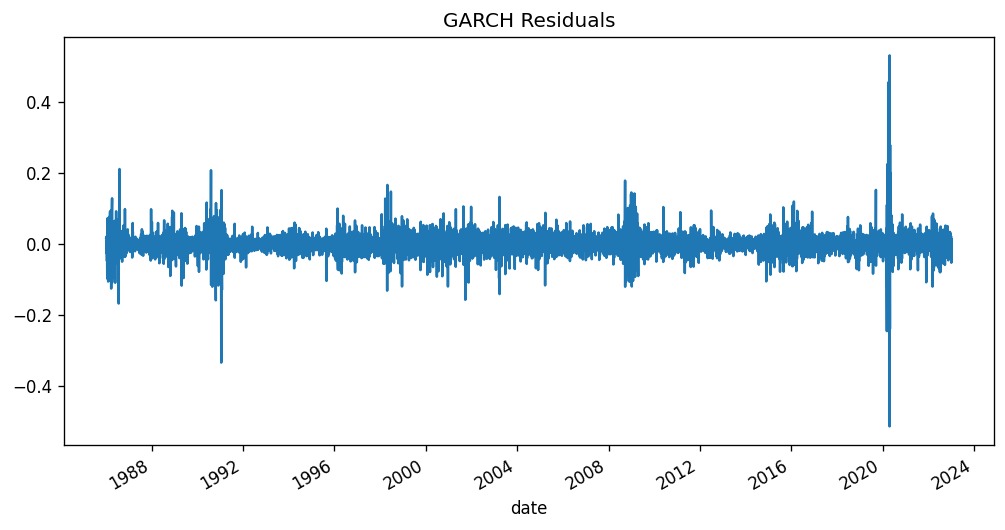

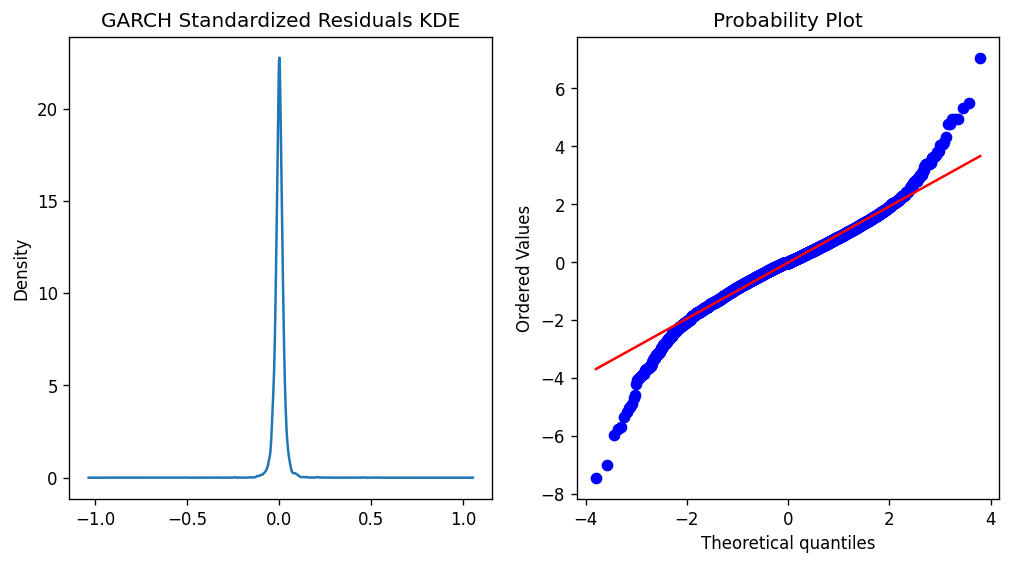

c:\Users\maxim\Documents\GitHub\work-bench\venv\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


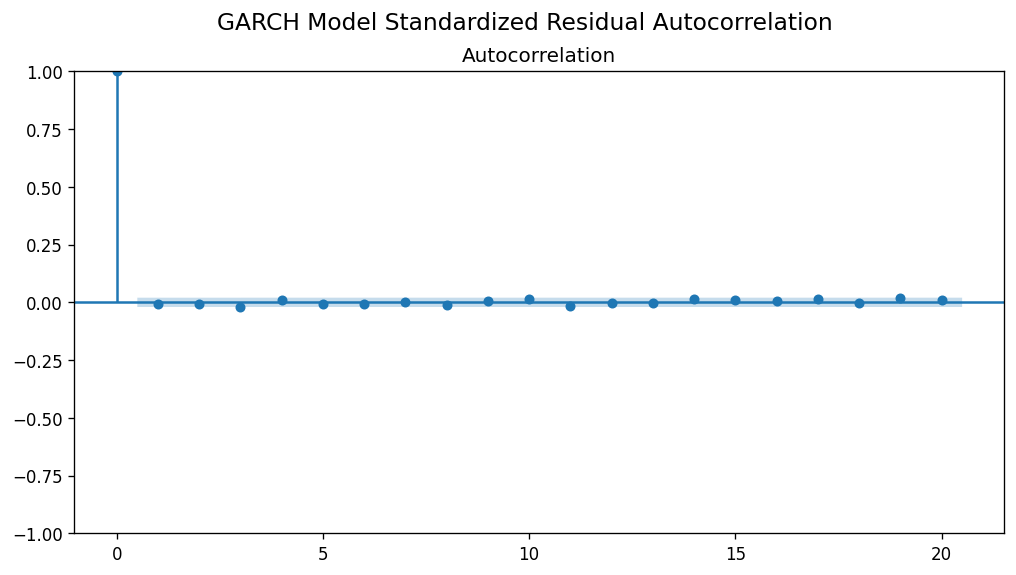

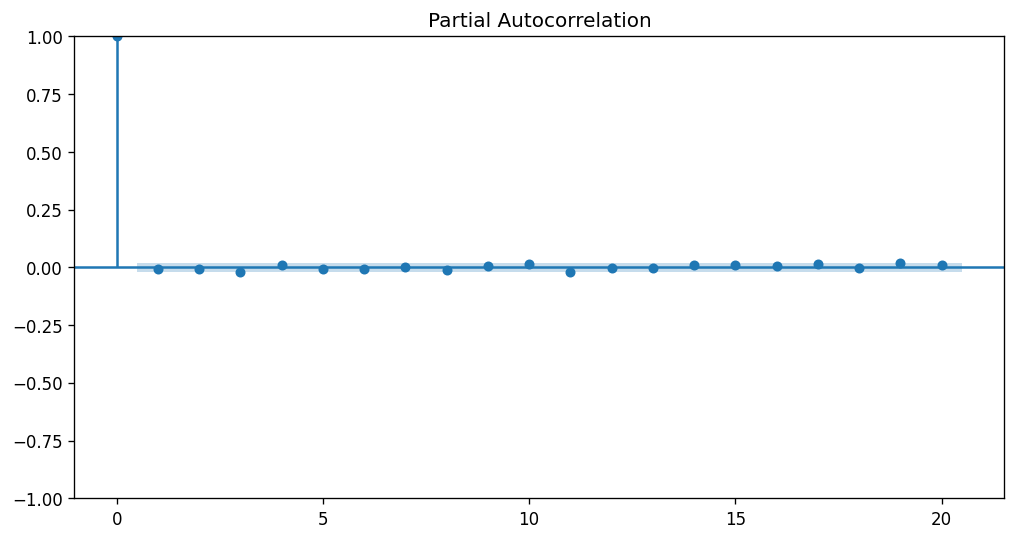

In [66]:
resid_full = model_fit_full.resid
st_resid_full = np.divide(resid_full, model_fit_full.conditional_volatility)
ts_plot(resid_full, st_resid_full)

In [67]:
garch_full = pd.DataFrame(model_fit_full._volatility)
garch_full.index = dfpc.index

Text(0.5, 1.0, 'Historical Volatility and GARCH estimation')

findfont: Font family ['stix'] not found. Falling back to DejaVu Sans.


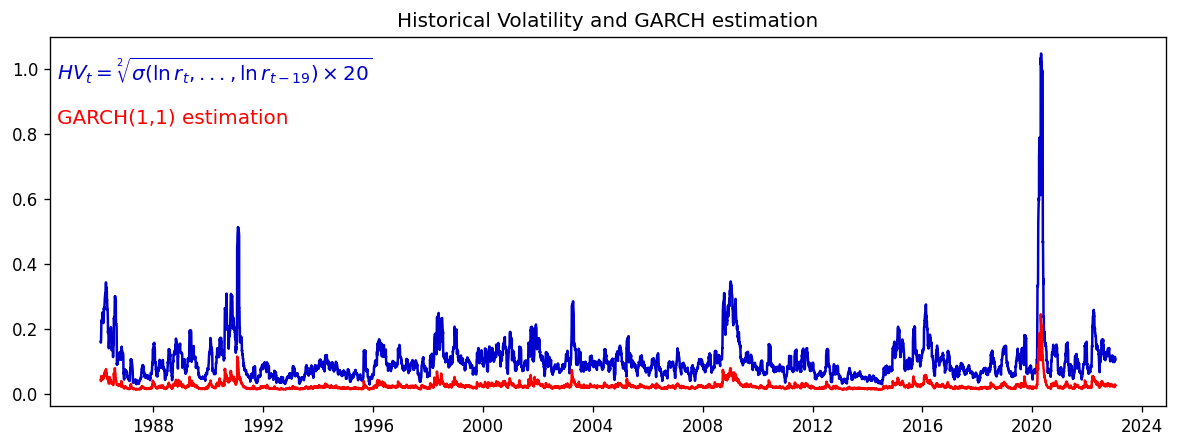

In [68]:
fig, ax = plt.subplots()

font1 = {'family': 'stix',
        'color':  'mediumblue',
        'weight': 'normal',
        'size': 12,
        }
font2 = {'family': 'stix',
        'color':  'red',
        'weight': 'normal',
        'size': 12,
        }

ax.plot(volatility.iloc[19:], color='mediumblue')
ax.plot(garch_full.iloc[19:], color='red')
fig.text(x=0.13, y=0.79, s=r'$HV_t = \sqrt[2]{\sigma (\ln{r_t}, ... , \ln{r_{t-19}})\times20}$', fontdict=font1)
fig.text(x=0.13, y=0.7, s=r'GARCH(1,1) estimation', fontdict=font2)
ax.set_title('Historical Volatility and GARCH estimation')

Estimating GARCH and EGARCH on train

In [69]:
# data split
y_train_v, y_test_v = dfpc[dfpc.index<'2022-12-01'], dfpc[(dfpc.index.year==2022) & (dfpc.index.month==12)]

# historical vol split
hv_train, hv_test = volatility[volatility.index<'2022-12-01'], volatility[(volatility.index.year==2022) & (volatility.index.month==12)]

GARCH

In [70]:
#Define a GARCH model
model_garch = arch_model(y_train_v,dist="Normal", vol = 'GARCH', p=1, q=1, rescale=False)
#Fit the model
model_fit_garch = model_garch.fit(disp='off')
#Summary of the model
model_fit_garch.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                     Constant Mean - GARCH Model Results                      
==============================================================================
Dep. Variable:               CrudeOil   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:                22680.2
Distribution:                  Normal   AIC:                          -45352.4
Method:            Maximum Likelihood   BIC:                          -45323.8
                                        No. Observations:                 9449
Date:                Mon, Apr 17 2023   Df Residuals:                     9448
Time:                        22:16:19   Df Model:                            1
                                 Mean Model                                 
============================================================================
                 coef    std err          t      P>|t|      95.0% Conf. Int.
----------------------------------------------------------------------------
mu         6.0094e-04  1.990e-04      3.020  2.530e-03 [2.109e-04,9.910e-04]
                              Volatility Model                              
============================================================================
                 coef    std err          t      P>|t|      95.0% Conf. Int.
----------------------------------------------------------------------------
omega      1.5308e-05  3.933e-12  3.892e+06      0.000 [1.531e-05,1.531e-05]
alpha[1]       0.1000  9.920e-03     10.081  6.722e-24   [8.056e-02,  0.119]
beta[1]        0.8800  7.067e-03    124.527      0.000     [  0.866,  0.894]
============================================================================

Covariance estimator: robust
"""

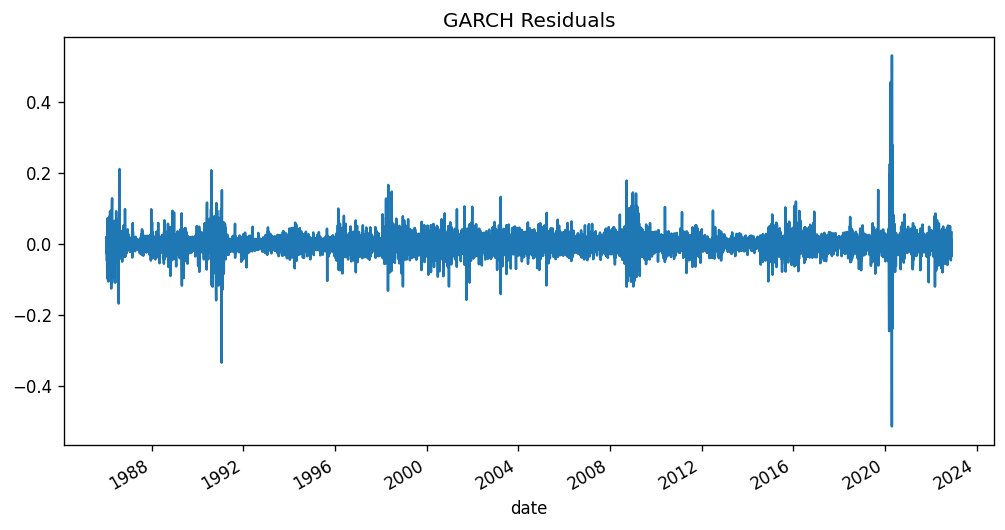

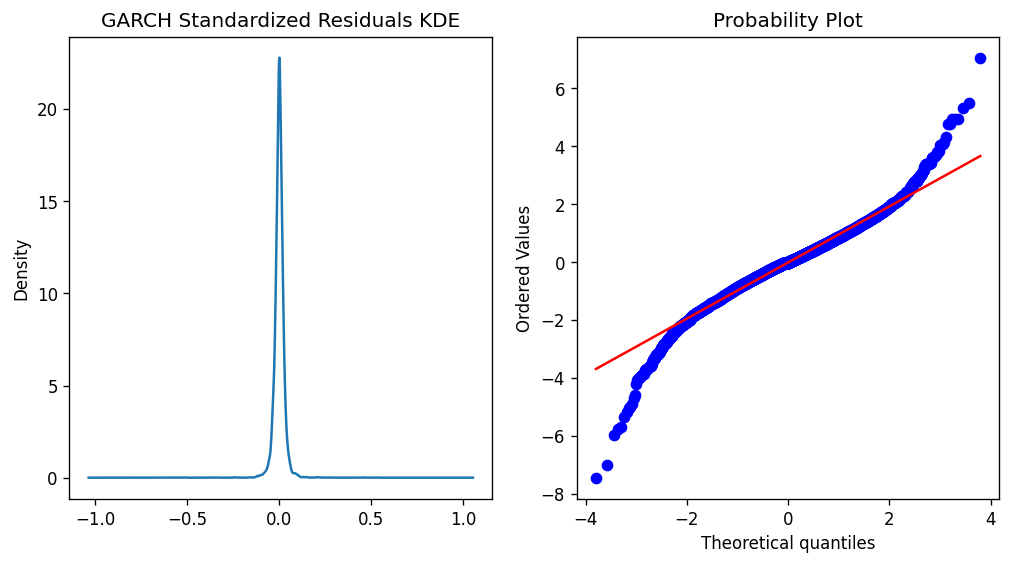

c:\Users\maxim\Documents\GitHub\work-bench\venv\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


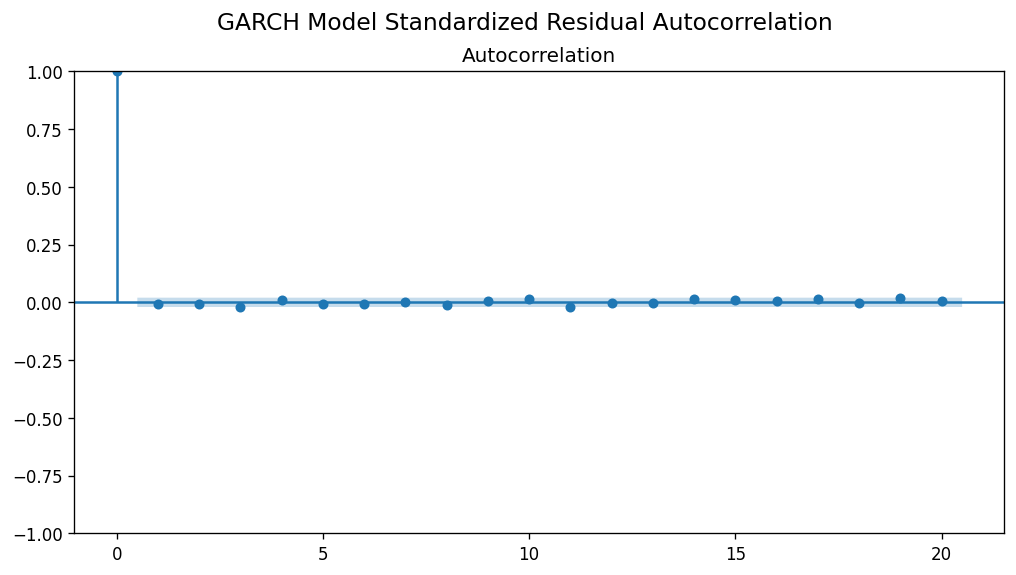

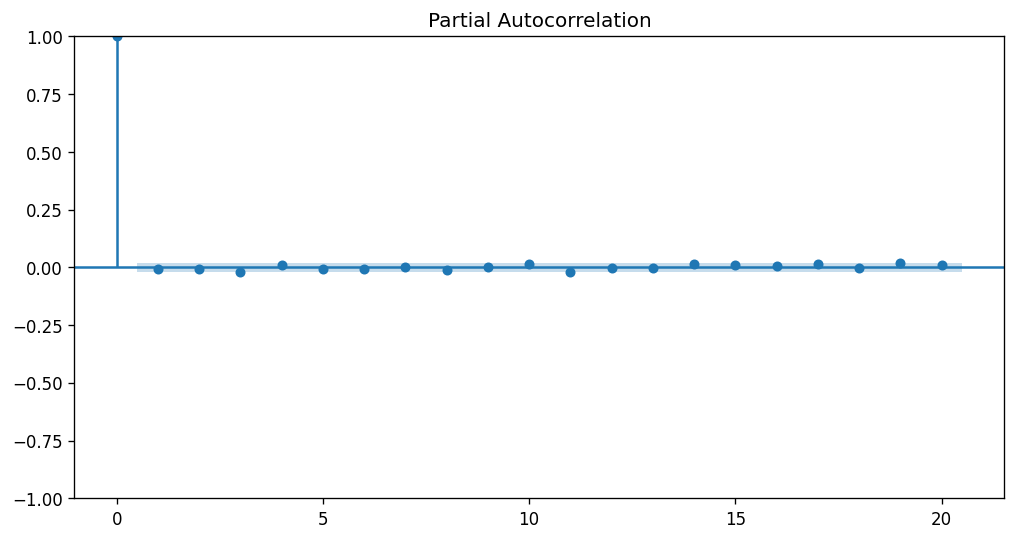

In [71]:
resid_garch = model_fit_garch.resid
st_resid_garch = np.divide(resid_garch, model_fit_garch.conditional_volatility)
ts_plot(resid_garch, st_resid_garch)

In [72]:
forecasts_garch = model_fit_garch.forecast(horizon=y_test_v.shape[0], reindex=False)

In [73]:
y_hat_garch = forecasts_garch.variance.values
y_hat_garch = pd.DataFrame(y_hat_garch.reshape(21))
y_hat_garch.index = y_test_v.index
y_hat_garch

,0
date,
2022-12-01,0.000577
2022-12-02,0.000581
2022-12-05,0.000585
2022-12-06,0.000588
2022-12-07,0.000592
2022-12-08,0.000595
2022-12-09,0.000599
2022-12-12,0.000602
2022-12-13,0.000605


In [74]:
garch_full[(garch_full.index.year==2022) & (garch_full.index.month==12)]

,0
date,
2022-12-01,0.024022
2022-12-02,0.022967
2022-12-05,0.022432
2022-12-06,0.024629
2022-12-07,0.025874
2022-12-08,0.026505
2022-12-09,0.025343
2022-12-12,0.024128
2022-12-13,0.024428


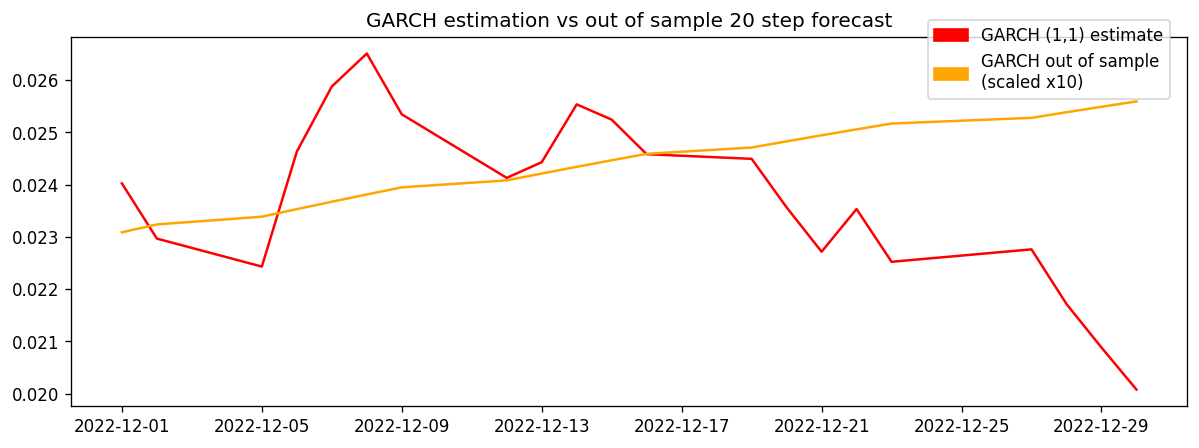

In [97]:
plt.plot(garch_full[(garch_full.index.year==2022) & (garch_full.index.month==12)], color='red')
plt.plot(y_hat_garch*40, color='orange')
plt.title('GARCH estimation vs out of sample 20 step forecast')
red_patch = mpatches.Patch(color='red', label='GARCH (1,1) estimate')
orange_patch = mpatches.Patch(color='orange', label='GARCH out of sample\n(scaled x10)')
plt.legend(handles=[red_patch, orange_patch], bbox_to_anchor=(0.76,0.81))

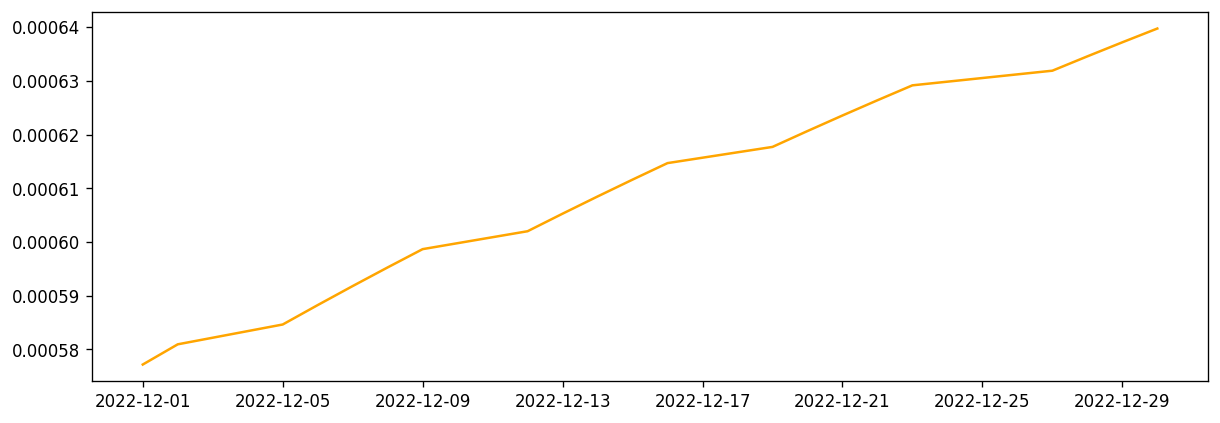

In [93]:
plt.plot(y_hat_garch, color='orange')

EGARCH

In [ ]:
#Define a EGARCH model
model_egarch = arch_model(y_train_v,dist="Normal", vol = 'EGARCH', p=1, q=1, rescale=False)
#Fit the model
model_fit_egarch = model_egarch.fit(disp='off')
#Summary of the model
model_fit_egarch.summary()

In [ ]:
resid_egarch = model_fit_egarch.resid
st_resid_egarch = np.divide(resid_garch, model_fit_egarch.conditional_volatility)
ts_plot(resid_egarch, st_resid_egarch)

In [ ]:
forecasts_egarch = model_fit_egarch.forecast(horizon=1, reindex=False)

In [ ]:
y_hat_egarch = forecasts_egarch.variance.values
y_hat_egarch = pd.DataFrame(y_hat_egarch.reshape(21))
y_hat_egarch.index = y_test_v.index
y_hat_egarch

In [ ]:
plt.plot(garch_full[(garch_full.index.year==2022) & (garch_full.index.month==12)])
plt.plot(y_hat_egarch*10)

---
Experiments - scaling results

In [ ]:
# calculating historical volatility
dft = pd.DataFrame()
dft['log_ret'] = np.log(df['CrudeOil']/df['CrudeOil'].shift())
dft.index = df.index
dft.dropna(inplace=True)
volatility = pd.DataFrame(dft['log_ret'].rolling(20).std()*20**.5)

In [ ]:
# putting garch train volatility output into df
garch_v = pd.DataFrame(model_fit_garch._volatility)
garch_v.index = y_train_v.index

In [ ]:
plt.plot(volatility[volatility.index<'2022-12-01'].iloc[19:])
plt.plot(garch_v.iloc[19:], color='red')

In [ ]:
plt.plot(volatility[volatility.index<'2022-12-01'].iloc[19:], alpha=0.5)
plt.plot(garch_v.iloc[19:]*4, color='red', alpha=0.2)